In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from keras.utils import np_utils
from tqdm import tqdm_notebook as tqdm
from time import time, sleep

/home/parubchenko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data

Some attempts to take into account varying duration of notes and different offsets between notes

In [70]:
ex_melodies = []
with open('dataset_A/extended_notes', 'rb') as filepath:
    ex_melodies = pickle.load(filepath)

In [152]:
melodies = []
with open('dataset_A/notes', 'rb') as filepath:
    melodies = pickle.load(filepath)

In [153]:
labels = []
with open('dataset_A/labels', 'rb') as filepath:
    labels = pickle.load(filepath)

In [154]:
indices = []
with open('dataset_A/indices', 'rb') as filepath:
    indices = pickle.load(filepath)

In [155]:
notes = []

for melody in tqdm(melodies):
    key = melody[0]
    if key in labels:
        notes.append('Start')
        for note in melody[1]:
            if '.' not in note or len(note.split('.')) <= 3:
                notes.append(note)
        notes.append('End')

In [72]:
ex_notes = []

for melody in tqdm(ex_melodies):
    key = melody[0]
    if key in labels:
        ex_notes.append('Start')
        for note in melody[1]:
            q = note.split(':')[0]
            try:
                offset = float(note.split(':')[1])
                if offset in [0.25, 0.5, 1, 1.5] and ('.' not in q or len(q.split('.')) <= 3):
                    ex_notes.append(note)
            except ValueError:
                pass
        ex_notes.append('End')

In [156]:
# Get all pitch names
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))
n_emots = len(set(val for val in labels.values()))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
# create a reversed dictionary to map integers to pitches
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

In [157]:
sequence_length = 32
network_input = []
emotion_input = []

for melody in tqdm(melodies):
    key = melody[0]
    if key in labels:
        emotion = labels[key]
        melody_notes = ['Start'] 
        for note in melody[1]:
            if '.' not in note or len(note.split('.')) <= 3:
                melody_notes.append(note)
        melody_notes += ['End']
        
        for i in range(0, len(melody_notes) - sequence_length, 1):
            sequence_in = melody_notes[i:i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            emotion_input.append(emotion)

In [75]:
sequence_length = 32
network_input = []
emotion_input = []

for melody in tqdm(ex_melodies):#(melodies):
    key = melody[0]
    if key in labels:
        emotion = labels[key]
        melody_notes = ['Start'] 
        for note in melody[1]:
            q = note.split(':')[0]
            try:
                offset = float(note.split(':')[1])
                if offset in [0.25, 0.5, 1, 1.5] and ('.' not in q or len(q.split('.')) <= 3):
                    melody_notes.append(note)
            except ValueError:
                pass
            #if '.' not in note or len(note.split('.')) <= 3:
            #    melody_notes.append(note)
        melody_notes += ['End']

        for i in range(0, len(melody_notes) - sequence_length, 1):
            sequence_in = melody_notes[i:i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            emotion_input.append(emotion)

In [158]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len, sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32')
    for i, seq in enumerate(sequences):
        current = [note_to_int.get(note) for note in seq[:max_len]]
        matrix[i, :len(current)] = current
    return matrix

## Many-to-Many LSTM

In [159]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [160]:
class NotTuple(nn.Module):
    def forward(self, input):
        return input[0]

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [161]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_vocab, emb_size=32, lstm_units=512, emotions_feature_size=3):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        self.classificator = nn.Sequential(
            nn.Embedding(n_vocab, emb_size),
            nn.LSTM(input_size=emb_size, hidden_size=64, 
                    num_layers=3, batch_first=True, dropout=0.3),
            NotTuple(),
            nn.Tanh(),
            Flatten(),
            nn.Linear(1984, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 3),
        ).cuda()
        self.classificator.load_state_dict(torch.load('weights\Classificator.pth'))
        self.classificator.train(False)
        
        self.units = lstm_units
        self.emotions = emotions_feature_size
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb_notes = nn.Embedding(n_tokens, emb_size)
        self.emb_emots = nn.Embedding(n_emots, emotions_feature_size)
        
        # a layer that converts emnbedded emotions features to 
        self.cnn_to_h0 = nn.Linear(emotions_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(emotions_feature_size, lstm_units)
        
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, 
                            num_layers=3, batch_first=True, dropout=0.3)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        #self.linear = nn.Linear(lstm_units, n_emots)
        #self.emots  = nn.Softmax(2)
        
    def classify(self, fragments):
        return self.classificator.forward(fragments)
    
    def forward(self, fragments, emotions, predict=False):
        """ 
        Apply the network in training mode. 
        :param emotions: a Variable containing inception vectors. shape: [batch, emotions_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, note_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, note_i, n_tokens]
        """
        fragments_emb = self.emb_notes(fragments)
        emotions_emb = self.emb_emots(emotions)
   
        c_0 = self.cnn_to_c0(emotions_emb)
        h_0 = self.cnn_to_h0(emotions_emb)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        h_0 = h_0.repeat(3, 1, 1)
        c_0 = c_0.repeat(3, 1, 1)
        h_0[1] = h_0[2] = torch.zeros_like(h_0[1])
        c_0[1] = c_0[2] = torch.zeros_like(c_0[2])

        lstm_out, _ = self.lstm(fragments_emb, (h_0, c_0))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        if not predict:
            out_emotion = self.classify(torch.argmax(logits, dim=2))
        else:
            out_emotion = torch.zeros(n_emots)
        #emots  = #self.linear(lstm_out)

        return logits, out_emotion     

In [167]:
def compute_loss(network, fragments, emotions, show=False):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    fragments_inp = fragments[:, :-1].contiguous()
    fragments_out = fragments[:, 1: ].contiguous()
    
    logits_out, emotions_out = network.forward(fragments_inp, emotions)

    loss_frag = F.cross_entropy(logits_out.view(-1, n_vocab), fragments_out.view(-1)).cuda()

    loss_emot = F.cross_entropy(emotions_out, emotions.view(-1)).cuda()

    if show:
        print('Differences:', torch.sum(torch.argmax(emotions_out, dim=1) != emotions.view(-1)).data.cpu().numpy())
        
    return loss_frag, loss_emot

In [169]:
Songs = np.array(network_input)
Emotions = np.array(emotion_input, dtype=np.int32)

In [170]:
indices = []
with open('my_data/indices', 'rb') as filepath:
    indices = pickle.load(filepath)

In [171]:
rev_indices = np.array([True] * Songs.shape[0])
rev_indices[indices] = False

In [172]:
from sklearn.model_selection import train_test_split

Song_train, Song_val, Emotion_train, Emotion_val = train_test_split(
    Songs[rev_indices], Emotions[rev_indices], test_size=0.1, shuffle=True)

In [175]:
def iterate_batches(fragments, emotions, batch_size):
    #permute indicies
    indices = np.random.permutation(np.arange(len(fragments)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        #get emotions
        batch_emotions = emotions[ix]
        #get songs fragments
        batch_fragments = fragments[ix]
        
        yield Variable(torch.LongTensor(batch_fragments)).cuda(), Variable(torch.LongTensor(batch_emotions)).cuda()

In [177]:
batch_size = 512
n_epochs = 50

In [178]:
network = CaptionNet(n_vocab).cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

val_minumum = np.inf
train_losses = []
t_n_losses = []
t_e_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs), desc='Epochs'):
    start = time()
    train_loss=0
    t_n_loss = 0
    t_e_loss = 0
    
    network.train(True)
    batches = 0
    for fragment_batch, emotion_batch in tqdm(
        iterate_batches(Song_train, Emotion_train, batch_size), leave=False, desc='Train'):
        batches += 1
        show = True if batches == 1 else False
        loss_n, loss_e = compute_loss(network, fragment_batch, emotion_batch, show)
        loss_t = loss_n + loss_e
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.cpu().numpy()
        t_n_loss += loss_n.data.cpu().numpy()
        t_e_loss += loss_e.data.cpu().numpy()
        
    train_loss /= batches
    t_n_loss /= batches
    t_e_loss /= batches
    train_losses.append(train_loss)
    t_n_losses.append(t_n_loss)
    t_e_losses.append(t_e_loss)
    
    val_loss=0
    network.train(False)
    batches = 0
    for fragment_batch, emotion_batch in iterate_batches(Song_val, Emotion_val, batch_size):
        batches += 1
        loss_n, loss_e = compute_loss(network, fragment_batch, emotion_batch)
        loss_t = loss_n + loss_e
        val_loss += loss_t.data.cpu().numpy()
    val_loss /= batches
    val_losses.append(val_loss)
    
    is_best = val_loss < val_minumum
    if is_best:
        val_minumum = val_loss
        torch.save(network.state_dict(), 'MtoM.pth')
    
    print("""Epoch: {}/{}
{:.0f}s - t_n loss: {:.3f} - t_e loss: {:.3f} - train_loss: {:.3f} - val loss: {:.3f}""".format(
        epoch+1, n_epochs, time() - start, t_n_loss, t_e_loss, train_loss, val_loss))

print("Finished!")

Differences: 224
Epoch: 1/50
45s - t_n loss: 2.857 - t_e loss: 0.702 - train_loss: 3.560 - val loss: 2.323


Differences: 56
Epoch: 2/50
45s - t_n loss: 1.776 - t_e loss: 0.275 - train_loss: 2.051 - val loss: 1.498


Differences: 47
Epoch: 3/50
44s - t_n loss: 1.376 - t_e loss: 0.210 - train_loss: 1.586 - val loss: 1.138


Differences: 41
Epoch: 4/50
45s - t_n loss: 1.168 - t_e loss: 0.181 - train_loss: 1.349 - val loss: 0.924


Differences: 32
Epoch: 5/50
44s - t_n loss: 1.036 - t_e loss: 0.167 - train_loss: 1.202 - val loss: 0.789


Differences: 17
Epoch: 6/50
45s - t_n loss: 0.942 - t_e loss: 0.148 - train_loss: 1.089 - val loss: 0.708


Differences: 25
Epoch: 7/50
45s - t_n loss: 0.870 - t_e loss: 0.135 - train_loss: 1.005 - val loss: 0.650


Differences: 20
Epoch: 8/50
44s - t_n loss: 0.812 - t_e loss: 0.126 - train_loss: 0.938 - val loss: 0.598


Differences: 18
Epoch: 9/50
44s - t_n loss: 0.766 - t_e loss: 0.117 - train_loss: 0.883 - val loss: 0.577


Differences: 21
Epoch: 10/50
45s - t_n loss: 0.729 - t_e loss: 0.111 - train_loss: 0.840 - val loss: 0.540


Differences: 19
Epoch: 11/50
45s - t_n loss: 0.698 - t_e loss: 0.106 - train_loss: 0.804 - val loss: 0.523


Differences: 24
Epoch: 12/50
44s - t_n loss: 0.672 - t_e loss: 0.102 - train_loss: 0.774 - val loss: 0.514


Differences: 15
Epoch: 13/50
44s - t_n loss: 0.649 - t_e loss: 0.097 - train_loss: 0.746 - val loss: 0.495


Differences: 9
Epoch: 14/50
44s - t_n loss: 0.631 - t_e loss: 0.092 - train_loss: 0.723 - val loss: 0.489


Differences: 12
Epoch: 15/50
44s - t_n loss: 0.614 - t_e loss: 0.089 - train_loss: 0.703 - val loss: 0.482


Differences: 15
Epoch: 16/50
45s - t_n loss: 0.600 - t_e loss: 0.084 - train_loss: 0.684 - val loss: 0.473


Differences: 15
Epoch: 17/50
45s - t_n loss: 0.586 - t_e loss: 0.084 - train_loss: 0.670 - val loss: 0.469


Differences: 21
Epoch: 18/50
45s - t_n loss: 0.575 - t_e loss: 0.081 - train_loss: 0.656 - val loss: 0.459


Differences: 15
Epoch: 19/50
44s - t_n loss: 0.564 - t_e loss: 0.079 - train_loss: 0.643 - val loss: 0.456


Differences: 15
Epoch: 20/50
44s - t_n loss: 0.555 - t_e loss: 0.075 - train_loss: 0.629 - val loss: 0.451


Differences: 16
Epoch: 21/50
45s - t_n loss: 0.546 - t_e loss: 0.077 - train_loss: 0.624 - val loss: 0.450


Differences: 16
Epoch: 22/50
44s - t_n loss: 0.538 - t_e loss: 0.075 - train_loss: 0.613 - val loss: 0.443


Differences: 12
Epoch: 23/50
44s - t_n loss: 0.530 - t_e loss: 0.072 - train_loss: 0.602 - val loss: 0.442


Differences: 15
Epoch: 24/50
44s - t_n loss: 0.523 - t_e loss: 0.071 - train_loss: 0.594 - val loss: 0.440


Differences: 11
Epoch: 25/50
44s - t_n loss: 0.517 - t_e loss: 0.072 - train_loss: 0.589 - val loss: 0.433


Differences: 8
Epoch: 26/50
44s - t_n loss: 0.511 - t_e loss: 0.069 - train_loss: 0.580 - val loss: 0.433


Differences: 11
Epoch: 27/50
44s - t_n loss: 0.506 - t_e loss: 0.070 - train_loss: 0.576 - val loss: 0.435


Differences: 15
Epoch: 28/50
44s - t_n loss: 0.501 - t_e loss: 0.069 - train_loss: 0.570 - val loss: 0.429


Differences: 14
Epoch: 29/50
45s - t_n loss: 0.495 - t_e loss: 0.066 - train_loss: 0.561 - val loss: 0.426


Differences: 16
Epoch: 30/50
45s - t_n loss: 0.491 - t_e loss: 0.067 - train_loss: 0.558 - val loss: 0.423


Differences: 15
Epoch: 31/50
44s - t_n loss: 0.487 - t_e loss: 0.065 - train_loss: 0.552 - val loss: 0.421


Differences: 12
Epoch: 32/50
44s - t_n loss: 0.482 - t_e loss: 0.065 - train_loss: 0.548 - val loss: 0.422


Differences: 13
Epoch: 33/50
45s - t_n loss: 0.478 - t_e loss: 0.066 - train_loss: 0.544 - val loss: 0.418


Differences: 8
Epoch: 34/50
45s - t_n loss: 0.474 - t_e loss: 0.065 - train_loss: 0.539 - val loss: 0.418


Differences: 12
Epoch: 35/50
45s - t_n loss: 0.471 - t_e loss: 0.064 - train_loss: 0.535 - val loss: 0.416


Differences: 17
Epoch: 36/50
45s - t_n loss: 0.468 - t_e loss: 0.065 - train_loss: 0.533 - val loss: 0.415


Differences: 13
Epoch: 37/50
45s - t_n loss: 0.464 - t_e loss: 0.063 - train_loss: 0.528 - val loss: 0.412


Differences: 13
Epoch: 38/50
45s - t_n loss: 0.462 - t_e loss: 0.063 - train_loss: 0.525 - val loss: 0.415


Differences: 12
Epoch: 39/50
45s - t_n loss: 0.458 - t_e loss: 0.062 - train_loss: 0.520 - val loss: 0.413


Differences: 13
Epoch: 40/50
45s - t_n loss: 0.456 - t_e loss: 0.062 - train_loss: 0.518 - val loss: 0.407


Differences: 14
Epoch: 41/50
45s - t_n loss: 0.452 - t_e loss: 0.062 - train_loss: 0.515 - val loss: 0.409


Differences: 12
Epoch: 42/50
45s - t_n loss: 0.450 - t_e loss: 0.062 - train_loss: 0.512 - val loss: 0.419


Differences: 8
Epoch: 43/50
45s - t_n loss: 0.447 - t_e loss: 0.062 - train_loss: 0.509 - val loss: 0.406


Differences: 10
Epoch: 44/50
45s - t_n loss: 0.445 - t_e loss: 0.061 - train_loss: 0.505 - val loss: 0.412


Differences: 11
Epoch: 45/50
45s - t_n loss: 0.443 - t_e loss: 0.061 - train_loss: 0.503 - val loss: 0.402


Differences: 13
Epoch: 46/50
45s - t_n loss: 0.440 - t_e loss: 0.061 - train_loss: 0.501 - val loss: 0.405


Differences: 11
Epoch: 47/50
45s - t_n loss: 0.438 - t_e loss: 0.060 - train_loss: 0.499 - val loss: 0.401


Differences: 11
Epoch: 48/50
45s - t_n loss: 0.436 - t_e loss: 0.061 - train_loss: 0.497 - val loss: 0.401


Differences: 9
Epoch: 49/50
44s - t_n loss: 0.434 - t_e loss: 0.061 - train_loss: 0.495 - val loss: 0.402


Differences: 15
Epoch: 50/50
44s - t_n loss: 0.432 - t_e loss: 0.060 - train_loss: 0.492 - val loss: 0.405
Finished!


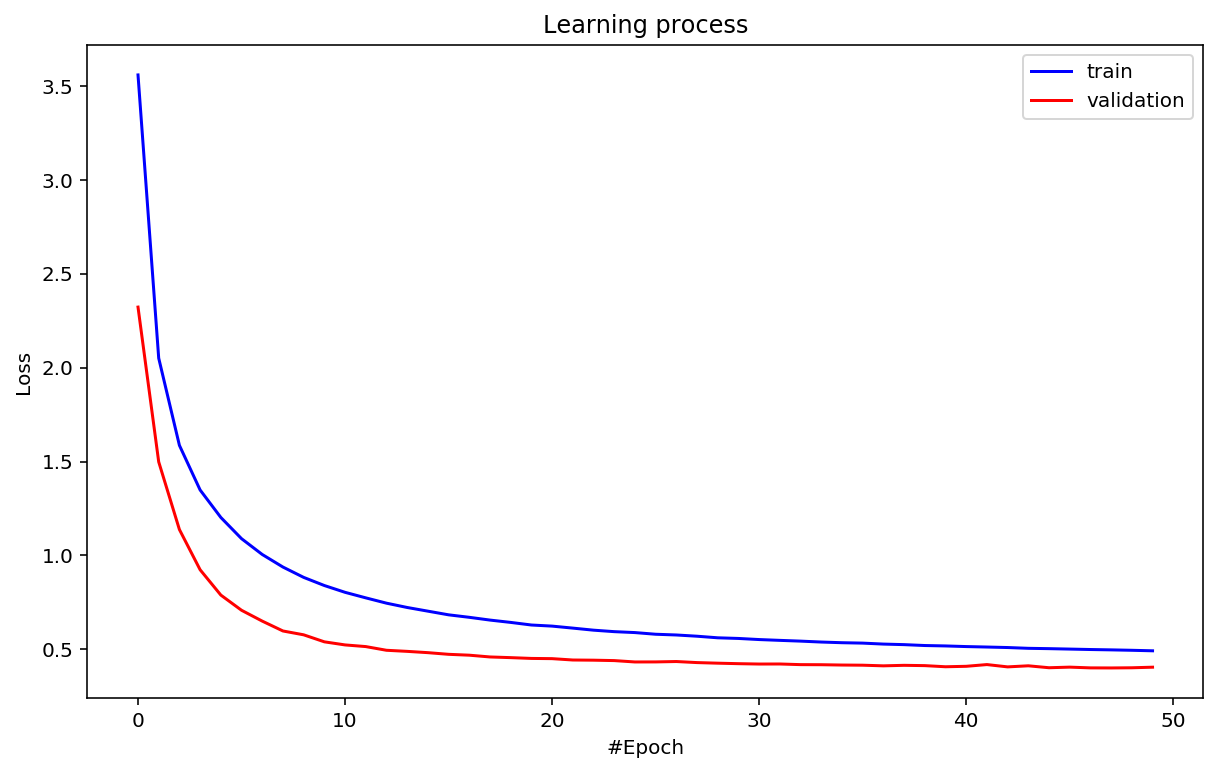

In [179]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.plot(train_losses, c='b', label='train')
ax.plot(val_losses, c='r', label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('#Epoch')
ax.set_title('Learning process')
ax.legend()
#fig.savefig('lp2.png')

In [180]:
def generate_fragment(emotion, fragment_prefix = ("Start",), 
                      t=1, sample=True, max_len=100):
    
    assert isinstance(emotion, int)

    fragment_prefix = list(fragment_prefix)
    emotion = Variable(torch.LongTensor([emotion]), requires_grad=False).cuda()
 
    for _ in tqdm(range(max_len)):

        prefix_ix = as_matrix([fragment_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), requires_grad=False).cuda()
        
        next_note_logits = network.forward(prefix_ix, emotion, predict=True)[0][0, -1]
        next_note_probs = F.softmax(next_note_logits, -1).data.cpu().numpy()
        
        assert len(next_note_probs.shape) == 1, 'probs must be one-dimensional'
        next_note_probs = next_note_probs ** t / np.sum(next_note_probs ** t) # apply temperature
        
        if sample:
            index = np.random.choice(range(n_vocab), p=next_note_probs) 
        else:
            index = int_to_note[np.argmax(next_note_probs)]
            
        next_note = int_to_note[index]
        fragment_prefix.append(next_note)

        if next_note == "End":
            break
            
    return fragment_prefix

In [186]:
outputs = {}
emotions = {'sad': 0, 'energetic': 1, 'romantic': 2}

for label, emotion in emotions.items(): 
    outputs[label] = generate_fragment(emotion)

In [187]:
from music21 import converter, instrument, note, chord, stream

In [188]:
output_songs = {}

for label, prediction_output in outputs.items():
    offset = 0
    output_notes = []
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if pattern in ['Start', 'End']:
            pass
        elif ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5
    output_songs[label] = output_notes

In [189]:
for label, output_notes in output_songs.items():
    midi_stream = stream.Stream(output_notes)
    print(label)
    midi_stream.write('midi', fp='{}_q.mid'.format(label))
    midi_stream.show('midi')

sad


energetic


romantic


In [190]:
midi = converter.parse('sad_q.mid')
midi.show('text')

{0.0} <music21.stream.Part 0x7f38d1f1e6a0>
    {0.0} <music21.stream.Voice 0x7f38d1f1e710>
        {0.0} <music21.note.Rest rest>
        {0.5} <music21.chord.Chord A4 C#4>
        {2.0} <music21.chord.Chord G#4 A4>
        {2.5} <music21.note.Note B>
        {3.5} <music21.chord.Chord G#4 A4>
        {4.5} <music21.note.Note F#>
        {5.5} <music21.note.Note F#>
        {6.0} <music21.note.Note F#>
        {6.5} <music21.note.Note F#>
        {7.0} <music21.note.Note B>
        {8.0} <music21.note.Note A>
        {9.0} <music21.note.Note A>
        {10.0} <music21.note.Note G#>
        {11.0} <music21.chord.Chord G#4 A4>
        {11.5} <music21.note.Note B>
        {12.5} <music21.chord.Chord G#4 A4>
        {13.0} <music21.note.Note B>
        {14.0} <music21.note.Note G#>
        {15.0} <music21.chord.Chord G#4 A4>
        {15.5} <music21.note.Note B>
        {16.5} <music21.note.Note D>
        {17.0} <music21.note.Note A>
        {17.5} <music21.note.Note C#>
        {19.0} <mu

In [191]:
midi = converter.parse('energetic_q.mid')
midi.show('text')

{0.0} <music21.stream.Part 0x7f38d1f8d4e0>
    {0.0} <music21.stream.Voice 0x7f38d1f8d550>
        {0.0} <music21.note.Rest rest>
        {0.5} <music21.chord.Chord F#4 B4>
        {1.5} <music21.note.Note D>
        {2.5} <music21.note.Note B>
        {3.5} <music21.note.Note G>
        {4.5} <music21.chord.Chord B4 D4>
        {6.0} <music21.chord.Chord F#4 B4>
        {7.5} <music21.note.Note D>
        {8.5} <music21.note.Note D>
        {9.5} <music21.note.Note F#>
        {10.5} <music21.note.Note F#>
        {12.0} <music21.note.Note F#>
        {12.5} <music21.note.Note D>
        {13.5} <music21.note.Note F#>
        {14.5} <music21.chord.Chord F#4 B4>
        {16.0} <music21.note.Note D>
        {17.5} <music21.note.Note C#>
        {18.5} <music21.note.Note B>
        {19.5} <music21.note.Note A>
        {20.5} <music21.note.Note C#>
        {21.5} <music21.note.Note B>
        {22.5} <music21.chord.Chord A4 E4>
        {23.5} <music21.note.Note B>
        {24.5} <music21.no